In [1]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot
from scipy import optimize
from scipy.io import loadmat
%matplotlib inline

In [2]:
data= pd.read_csv(os.path.join('fashion-mnist_train.csv'))
data.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,9,8,...,103,87,56,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,34,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,14,53,99,...,0,0,0,0,63,53,31,0,0,0
3,2,0,0,0,0,0,0,0,0,0,...,137,126,140,0,133,224,222,56,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [3]:
#Initialise a dictionary and map the 'label' from the dataframe 
#to the specific kind of wearable it is.
NumtoLabels = np.array(["T-Shirt/Top", "Trouser", "Pullover", "Dress", "Coat", "Sandals", "Shirt", "Sneaker", "Bag", "Ankle boots"])
LabelsToNum = {}
for i in range(10):
    LabelsToNum.update({NumtoLabels[i] : i})


In [4]:
#Segregate the data, normalise the feature vector, initialise a dictionary corresponding to the output array and map it. 
#Print a subset of the data like we did for the hand-written digit classification

mi = data.min()
ma = data.max()
del mi['label']
del ma['label']

def data_clean_Display(data): # 'data' is a pandas datafram                   
    y = []
    for i in data['label']:
        y.append(i)
    data.dropna(subset=['label'], inplace=True)
    del data['label']
    data = (data - mi)/(ma - mi)
    num = 0
    X = []
    for i in data:
        X.append(data[i])
    X = np.array(X).T
    return X, np.array(y)


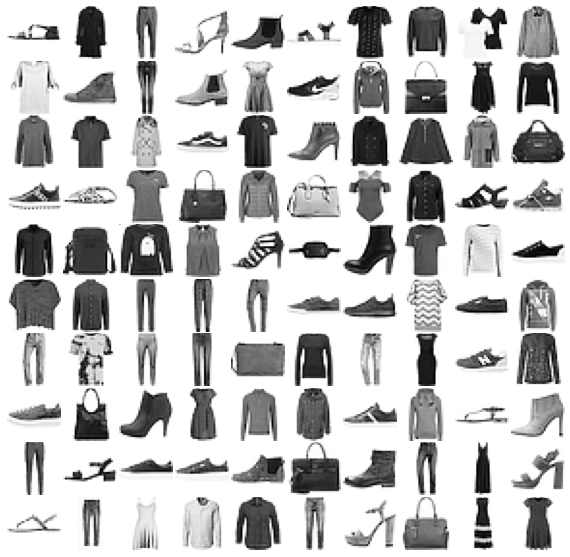

In [5]:
X, y = data_clean_Display(data)

rand_indices = np.random.choice(X.shape[0], 100, replace=False)
sel = (X[rand_indices, :])

fig, ax_array = pyplot.subplots(10, 10, figsize=(10, 10))
fig.subplots_adjust(wspace=0.025, hspace=0.025)

ax_array = ax_array.ravel()
for i, ax in enumerate(ax_array):
    h = ax.imshow(sel[i].reshape(28, 28, order='F').T,
                  cmap='Greys', extent=[0, 1, 0, 1])
    ax.axis('off')

In [6]:
#Implement the sigmoid function
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

In [7]:
# Prediction based on trained model
# Use sigmoid function to calculate probability rounded off to either 0 or 1
#Prediction function for single hidden layer.
def predictSingleHiddenLayer(w1, w2, X): 
#     pass    # 'p' should be a vector of size equal to that of vector 'y'
    if X.ndim==1:
        X=X[None]
    
    m=X.shape[0]
    num_labels= w2.shape[0]
    
    p= np.zeros(m)
    
    a1= np.concatenate([np.ones((m,1)), X], axis=1) #Input layer
    
    a2= sigmoid(a1.dot(w1.T)) #Hidden Layer
    
    a2= np.concatenate([np.ones((a2.shape[0],1)), a2 ], axis=1) #Activation of 2nd layer
    
    a3= sigmoid(a2.dot(w2.T))
    
    p= np.argmax(a3, axis=1)
    return p

In [8]:
#Prediction function for double hidden layer.
def predictDoubleHiddenLayer(w1, w2, w3, X): 
#     pass    # 'p' should be a vector of size equal to that of vector 'y'
    if X.ndim==1:
        X=X[None]
    
    m=X.shape[0]
    num_labels= w3.shape[0]
    
    p= np.zeros(m)
    
    a1= np.concatenate([np.ones((m,1)), X], axis=1) #Input layer
    
    a2= sigmoid(a1.dot(w1.T)) #Hidden Layer
    
    a2= np.concatenate([np.ones((a2.shape[0],1)), a2 ], axis=1) #Activation of 2nd layer
    
    a3= sigmoid(a2.dot(w2.T))
    
    a3= np.concatenate([np.ones((a3.shape[0],1)), a3 ], axis=1) #Activation of 3rd layer
    
    a4= sigmoid(a3.dot(w3.T))
    
    p= np.argmax(a4, axis=1)
    return p

In [9]:
#implement the gradient of the sigmoid function
def sigmoidGradient(z):
    g= sigmoid(z)*(1-sigmoid(z))

    return g

In [10]:
# Setup the parameters you will use for this exercise
input_layer_size  =  784
hidden_layer_size_One =  25  
hidden_layer_size_Two =  25
num_labels = 10          

In [11]:
#randomly initialise weights.
def randInitializeWeights(L_in, L_out, epsilon_init=0.12):
    return np.random.rand(L_out, L_in+1)*2*epsilon_init-epsilon_init

In [12]:
initial_w1 = randInitializeWeights(input_layer_size, hidden_layer_size_One)

initial_w2_1 = randInitializeWeights(hidden_layer_size_One, num_labels)             # For Single hidden Layer model
initial_w2_2 = randInitializeWeights(hidden_layer_size_One, hidden_layer_size_Two)  # For Double hidden Layer model

initial_w3 = randInitializeWeights(hidden_layer_size_Two, num_labels)    #only when you're using the Second Hidden Layer

# Unroll parameters into a single array

initial_nn_params1 = np.concatenate([initial_w1.ravel(), initial_w2_1.ravel()], axis=0)
initial_nn_params2 = np.concatenate([initial_w1.ravel(), initial_w2_2.ravel(), initial_w3.ravel()], axis=0)


In [13]:
# nnCostFunction is for single hidden Layer model
# nnCostFunctionNew is for single hidden Layer model

def nnCostFunction(nn_params,
                   input_layer_size,
                   hidden_layer_size,
                   num_labels,
                   X, y, lambda_=0.0):
    
    w1 = np.reshape(nn_params[:hidden_layer_size * (input_layer_size + 1)],
                        (hidden_layer_size, (input_layer_size + 1)))

    w2 = np.reshape(nn_params[(hidden_layer_size * (input_layer_size + 1)):],
                        (num_labels, (hidden_layer_size + 1)))

    m = y.size
         
    J = 0
    w1_grad = np.zeros(w1.shape)
    w2_grad = np.zeros(w2.shape)

    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(w1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(w2.T))
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    
    temp1 = w1
    temp2 = w2
    
    
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])))
    
    J = (-1 / m) * np.sum((np.log(a3) * y_matrix) + np.log(1 - a3) * (1 - y_matrix)) + reg_term
  
    # Backpropogation
    delta_3= a3-y_matrix #Error of O/P layer
    delta_2= delta_3.dot(w2)[:, 1:]*sigmoidGradient(a1.dot(w1.T)) #Error of hidden layer.
    
    Delta1= delta_2.T.dot(a1)
    Delta2= delta_3.T.dot(a2)

    

    
    w1_grad= (1/m)*Delta1
    w2_grad= (1/m)*Delta2
    
    w1_grad[:, 1:]=  w1_grad[:, 1:] + (lambda_/m)*w1[:, 1:]
    w2_grad[:, 1:]=  w2_grad[:, 1:] + (lambda_/m)*w2[:, 1:]
    
    grad= np.concatenate([w1_grad.ravel(), w2_grad.ravel()]) 
   
    return J,grad

def nnCostFunctionNew(nn_params,
                   input_layer_size,
                   hidden_layer_size1,
                   hidden_layer_size2,
                   num_labels,
                   X, y, lambda_=0.0):
    
    index1 = hidden_layer_size1 * (input_layer_size + 1)
    index2 = index1+ hidden_layer_size2 * (hidden_layer_size1 + 1)
    w1 = np.reshape(nn_params[:index1],
                        (hidden_layer_size1, (input_layer_size + 1)))

    w2 = np.reshape(nn_params[index1:index2],
                        (hidden_layer_size2, (hidden_layer_size1 + 1)))
    
    w3 = np.reshape(nn_params[index2:], (num_labels, (hidden_layer_size2 + 1)))

    m = y.size
         
    J = 0
    w1_grad = np.zeros(w1.shape)
    w2_grad = np.zeros(w2.shape)
    w3_grad = np.zeros(w3.shape)
    
    
    a1 = np.concatenate([np.ones((m, 1)), X], axis=1)
    
    a2 = sigmoid(a1.dot(w1.T))
    a2 = np.concatenate([np.ones((a2.shape[0], 1)), a2], axis=1)
    
    a3 = sigmoid(a2.dot(w2.T))
    a3 = np.concatenate([np.ones((a3.shape[0], 1)), a3], axis=1)
    
    a4 = sigmoid(a3.dot(w3.T))
    y_matrix = y.reshape(-1)
    y_matrix = np.eye(num_labels)[y_matrix]
    
    temp1 = w1
    temp2 = w2
    temp3 = w3
    
    # Add regularization term
    
    reg_term = (lambda_ / (2 * m)) * (np.sum(np.square(temp1[:, 1:])) + np.sum(np.square(temp2[:, 1:])) + np.sum(np.square(temp3[:, 1:])))
    
    J = (-1 / m) * np.sum((np.log(a4) * y_matrix) + np.log(1 - a4) * (1 - y_matrix)) + reg_term
  
    # Backpropogation
    delta_4 = a4 - y_matrix
    delta_3 = delta_4.dot(w3)[:, 1:]*sigmoidGradient(a2.dot(w2.T))
    delta_2 = delta_3.dot(w2)[:, 1:]*sigmoidGradient(a1.dot(w1.T))
    
    Delta1= delta_2.T.dot(a1)
    Delta2= delta_3.T.dot(a2)
    Delta3= delta_4.T.dot(a3)

    
    # Add regularization to gradient

    
    w1_grad= (1/m)*Delta1
    w2_grad= (1/m)*Delta2
    w3_grad= (1/m)*Delta3
    
    w1_grad[:, 1:]=  w1_grad[:, 1:] + (lambda_/m)*w1[:, 1:]
    w2_grad[:, 1:]=  w2_grad[:, 1:] + (lambda_/m)*w2[:, 1:]
    w3_grad[:, 1:]=  w3_grad[:, 1:] + (lambda_/m)*w3[:, 1:]
    
    grad= np.concatenate([w1_grad.ravel(), w2_grad.ravel(), w3_grad.ravel()]) 
   
    return J,grad

In [14]:
# Write code to pass the cost function to scipy's optimise.minimize

options= {'maxiter': 250}

lambda_ = 0.1

# single hidden layer
costFunction1 = lambda p: nnCostFunction(p, input_layer_size, 
                                        hidden_layer_size_One,
                                        num_labels, X, y, lambda_)

# double hidden layer
costFunction2 = lambda p: nnCostFunctionNew(p, input_layer_size, # p == nn_param
                                        hidden_layer_size_One,
                                        hidden_layer_size_Two,
                                        num_labels, X, y, lambda_)

# single hidden layer
res1 = optimize.minimize(costFunction1,
                        initial_nn_params1,
                        jac=True,
                        method='TNC',
                        options=options)

# double hidden layer
res2 = optimize.minimize(costFunction2,
                        initial_nn_params2,
                        jac=True,
                        method='TNC',
                        options=options)

In [15]:
#Read in the test data at this point

data_test= pd.read_csv(os.path.join('fashion-mnist_test.csv'))
data_test.head()


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [16]:
#Break the nn_params into weights depending on how many layers you're using and 
#pass it to the predict function according to the number of layers you're using.

# single hidden layer
nn_params1 = res1.x 

#weights
w1_1 = np.reshape(nn_params1[:hidden_layer_size_One * (input_layer_size + 1)],
                    (hidden_layer_size_One, (input_layer_size + 1)))

w2_1 = np.reshape(nn_params1[(hidden_layer_size_One * (input_layer_size + 1)):],
                    (num_labels, (hidden_layer_size_One + 1)))


# double hidden layer
nn_params2 = res2.x

index1 = hidden_layer_size_One * (input_layer_size + 1)
index2 = index1+ hidden_layer_size_Two * (hidden_layer_size_One + 1)

#weights
w1_2 = np.reshape(nn_params2[:index1],
                    (hidden_layer_size_One, (input_layer_size + 1)))

w2_2 = np.reshape(nn_params2[index1:index2],
                    (hidden_layer_size_Two, (hidden_layer_size_One + 1)))

w3_2 = np.reshape(nn_params2[index2:], (num_labels, (hidden_layer_size_Two + 1)))


#check how the learned weights are performing on the test data.

#Single Hidden Layer Model
pred_1 = predictSingleHiddenLayer(w1_1, w2_1, X)
print('Training Set Accuracy of Single Hidden Layer Model: %f' % (np.mean(pred_1 == y) * 100))

X1, y1 = data_clean_Display(data_test)
p_1 = predictSingleHiddenLayer(w1_1, w2_1, X1)
print(' Testing Set Accuracy of Single Hidden Layer Model: %f\n' % (np.mean(p_1 == y1) * 100))

#Double Hidden Layer Model
pred_2 = predictDoubleHiddenLayer(w1_2, w2_2, w3_2, X)
print('Training Set Accuracy of Double Hidden Layer Model: %f' % (np.mean(pred_2 == y) * 100))

p_2 = predictDoubleHiddenLayer(w1_2, w2_2, w3_2, X1)
print(' Testing Set Accuracy of Double Hidden Layer Model: %f' % (np.mean(p_2 == y1) * 100))

Training Set Accuracy of Single Hidden Layer Model: 92.170000
 Testing Set Accuracy of Single Hidden Layer Model: 86.666667

Training Set Accuracy of Double Hidden Layer Model: 77.290000
 Testing Set Accuracy of Double Hidden Layer Model: 70.000000


 Predicted Items with Single Hidden Layer Model : 


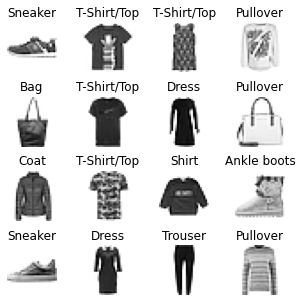

In [17]:
#Question-4 : 
rand_indices = np.random.choice(X1.shape[0], 16, replace=False)
sel = (X1[rand_indices, :])
print(" Predicted Items with Single Hidden Layer Model : ")
fig, ax_array = pyplot.subplots(4, 4, figsize=(5, 5))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

ax_array = ax_array.ravel()
for i, ax in enumerate(ax_array):
    # Display Image
    h = ax.imshow(sel[i].reshape(28, 28, order='F').T,
                  cmap='Greys', extent=[0, 1, 0, 1])
    ax.axis('off')
    ax.set_title(NumtoLabels[p_1[rand_indices[i]]])

 Predicted Items with Double Hidden Layer Model : 


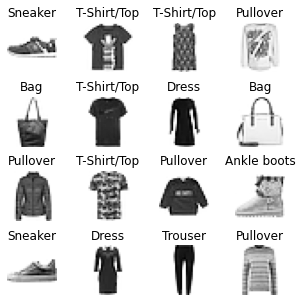

In [18]:
print(" Predicted Items with Double Hidden Layer Model : ")
fig, ax_array = pyplot.subplots(4, 4, figsize=(5, 5))
fig.subplots_adjust(wspace=0.5, hspace=0.5)

ax_array = ax_array.ravel()
for i, ax in enumerate(ax_array):
    # Display Image
    h = ax.imshow(sel[i].reshape(28, 28, order='F').T,
                  cmap='Greys', extent=[0, 1, 0, 1])
    ax.axis('off')
    ax.set_title(NumtoLabels[p_2[rand_indices[i]]])

In [896]:
#COMPARE the prediction efficiency of the NN from one hidden layer to double hidden layer

## Comments:

After testing the model for various number of optimisation iterations, it was observed that double hidden layer model has little lesser accuracy in training data but have relatively greater difference in accuracy of testing data with double hidden layer being lower.

By this, we can say that Double hidden layer Model lack in generalisation of the data as compared to Single hidden layer. 
We can aslo conclude that single hidden layer model is a better model for this particular classification as compared to double hidden layer model.